In [33]:
import os
import torch
import torch.nn as nn
from lion_pytorch import Lion
import torchvision.transforms as transforms
import torch.optim as optim
from th import coatnet, CNNModel, trainer, loader, plot, evaluator

In [34]:
#HyperParameters
img_size = (224, 224)
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
optimizer_class = Lion
criterion = nn.BCELoss()
learning_rate = 1e-4
num_epochs = 10

In [35]:
#Basic CNN Model Build
cnn_model = CNNModel(img_size=img_size).to(device)
cnn_model_path = os.path.join("pths", f"stroke_detection_model_{cnn_model.__class__.__name__}.pth")

In [36]:
#Data load
data_dir = "dataset"
test_dir = "test_dataset"

#train_loader, val_loader = loader(data_dir, transform=transform, split_ratio=0.8, batch_size=batch_size, shuffle=True)
train_loader = loader(data_dir, transform=transform, batch_size=batch_size, shuffle=True)

test_loader_head_ct = loader(os.path.join(test_dir, "head_ct"), transform=transform, batch_size=batch_size, shuffle=False)
test_loader_brain_ct = loader(os.path.join(test_dir, "brain_ct"), transform=transform, batch_size=batch_size, shuffle=False)
head_ct_samples, brain_ct_samples = len(test_loader_head_ct.dataset), len(test_loader_head_ct.dataset)
total_samples = head_ct_samples + brain_ct_samples

val_loader = torch.utils.data.DataLoader(
    torch.utils.data.ConcatDataset([test_loader_head_ct.dataset, test_loader_brain_ct.dataset]),
    batch_size=batch_size, shuffle=False
)

In [37]:
#Train the CNN model
cnn_train_losses, cnn_train_accuracies, cnn_val_losses, cnn_val_accuracies = trainer(cnn_model, train_loader, val_loader, num_epochs, 
                                                                                     criterion, optimizer_class, learning_rate, 
                                                                                     model_path=cnn_model_path, device=device)

Epoch 1/10, Training Loss: 0.5010, Training Accuracy: 74.97%, Validation Accuracy: 58.24%
Epoch 2/10, Training Loss: 0.2804, Training Accuracy: 88.32%, Validation Accuracy: 57.72%
Epoch 3/10, Training Loss: 0.1279, Training Accuracy: 95.10%, Validation Accuracy: 62.05%
Epoch 4/10, Training Loss: 0.0692, Training Accuracy: 97.26%, Validation Accuracy: 54.10%
Epoch 5/10, Training Loss: 0.0466, Training Accuracy: 98.36%, Validation Accuracy: 52.65%
Epoch 6/10, Training Loss: 0.0374, Training Accuracy: 98.73%, Validation Accuracy: 61.37%
Epoch 7/10, Training Loss: 0.0293, Training Accuracy: 98.93%, Validation Accuracy: 60.69%
Epoch 8/10, Training Loss: 0.0280, Training Accuracy: 99.11%, Validation Accuracy: 57.95%
Epoch 9/10, Training Loss: 0.0297, Training Accuracy: 99.09%, Validation Accuracy: 54.92%
Epoch 10/10, Training Loss: 0.0201, Training Accuracy: 99.38%, Validation Accuracy: 55.30%


In [38]:
#Evaluate the CNN model
cnn_accuracy_head_ct = evaluator(cnn_model, test_loader_head_ct, device)
cnn_accuracy_brain_ct = evaluator(cnn_model, test_loader_brain_ct, device)

cnn_total_accuracy = (cnn_accuracy_head_ct * head_ct_samples + cnn_accuracy_brain_ct * brain_ct_samples) / total_samples

print(f'Head CT Test Accuracy: {cnn_accuracy_head_ct * 100:.2f}%')
print(f'Brain CT Test Accuracy: {cnn_accuracy_brain_ct * 100:.2f}%')
print(f'Total Accuracy: {cnn_total_accuracy * 100:.2f}%')

Head CT Test Accuracy: 54.00%
Brain CT Test Accuracy: 55.34%
Total Accuracy: 54.67%


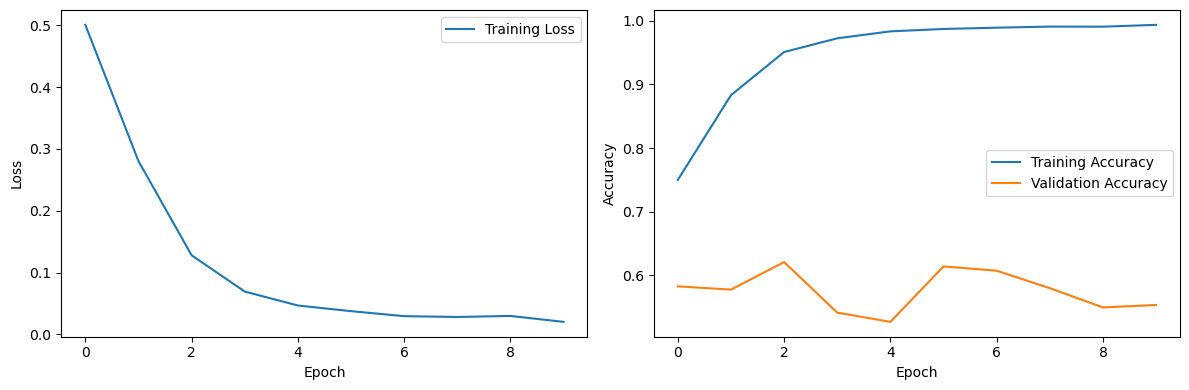

In [39]:
#Plot the CNN model metrics
plot(cnn_train_losses, cnn_train_accuracies, cnn_val_losses, cnn_val_accuracies)

In [40]:
#CoAtNet Build
coatnet_model = coatnet(image_size=img_size, num_classes=1).to(device)
coatnet_model_path = f"stroke_detection_model_{coatnet_model.__class__.__name__}.pth"

In [41]:
#Train the CoAtNet model
coatnet_train_losses, coatnet_train_accuracies, coatnet_val_losses, coatnet_val_accuracies = trainer(coatnet_model, train_loader, val_loader, num_epochs, 
                                                                                                     criterion, optimizer_class, learning_rate, 
                                                                                                     model_path=coatnet_model_path, device=device)

Epoch 1/10, Training Loss: 0.5524, Training Accuracy: 73.33%, Validation Accuracy: 70.95%
Epoch 2/10, Training Loss: 0.3106, Training Accuracy: 87.42%, Validation Accuracy: 71.55%
Epoch 3/10, Training Loss: 0.2156, Training Accuracy: 91.83%, Validation Accuracy: 72.18%
Epoch 4/10, Training Loss: 0.1635, Training Accuracy: 93.79%, Validation Accuracy: 73.89%
Epoch 5/10, Training Loss: 0.1230, Training Accuracy: 95.58%, Validation Accuracy: 71.80%
Epoch 6/10, Training Loss: 0.1046, Training Accuracy: 96.05%, Validation Accuracy: 70.07%
Epoch 7/10, Training Loss: 0.0930, Training Accuracy: 96.72%, Validation Accuracy: 65.24%
Epoch 8/10, Training Loss: 0.0885, Training Accuracy: 96.80%, Validation Accuracy: 72.05%
Epoch 9/10, Training Loss: 0.0783, Training Accuracy: 96.90%, Validation Accuracy: 71.56%
Epoch 10/10, Training Loss: 0.0627, Training Accuracy: 97.85%, Validation Accuracy: 70.95%


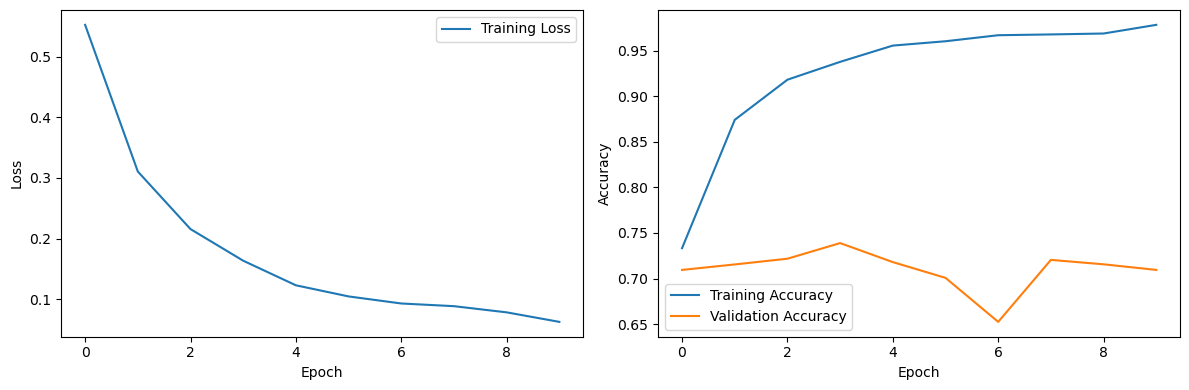

In [42]:
#Plot the CoAtNet model metrics
plot(coatnet_train_losses,  coatnet_train_accuracies, coatnet_val_losses, coatnet_val_accuracies)

In [43]:
#Evaluate the CoAtNet model
coatnet_accuracy_head_ct = evaluator(coatnet_model, test_loader_head_ct, device)
coatnet_accuracy_brain_ct = evaluator(coatnet_model, test_loader_brain_ct, device)

coatnet_total_accuracy = (coatnet_accuracy_head_ct * head_ct_samples + coatnet_accuracy_brain_ct * brain_ct_samples) / total_samples

print(f'CoAtNet Head CT Test Accuracy: {coatnet_accuracy_head_ct * 100:.2f}%')
print(f'CoAtNet Brain CT Test Accuracy: {coatnet_accuracy_brain_ct * 100:.2f}%')
print(f'CoAtNet Total Accuracy: {coatnet_total_accuracy * 100:.2f}%')

CoAtNet Head CT Test Accuracy: 53.00%
CoAtNet Brain CT Test Accuracy: 71.47%
CoAtNet Total Accuracy: 62.24%
